In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 16GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=16024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

2023-06-09 09:47:44.781672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 09:47:44.849211: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


1 Physical GPUs, 1 Logical GPUs


2023-06-09 09:47:45.795621: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 09:47:45.795654: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 09:47:45.802565: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 09:47:45.802588: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:843] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-09 09:47:45.802599: I tensorflow/compiler/xla/stream_executo

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers, regularizers


class CustomRNNCell(Layer):
    def __init__(
        self,
        output_dim,
        state_size,
        activation=tf.nn.tanh,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        recurrent_initializer="orthogonal",
        bias_initializer="zeros",
        initial_state_initializer="zeros",
        kernel_regularizer=None,
        recurrent_regularizer=None,
        bias_regularizer=None,
        trainable_initial_weights=False,
        **kwargs
    ):
        super(CustomRNNCell, self).__init__(**kwargs)

        self.output_dim = output_dim
        self.state_size = state_size
        self.activation = tf.keras.activations.get(activation)
        self.use_bias = use_bias

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.recurrent_initializer = initializers.get(recurrent_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.initial_state_initializer = initializers.get(initial_state_initializer)

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.trainable_initial_weights = trainable_initial_weights

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1] + self.state_size, self.output_dim),
            initializer=self.kernel_initializer,
            name="kernel",
            regularizer=self.kernel_regularizer,
        )

        self.recurrent_kernel = self.add_weight(
            shape=(input_shape[-1] + self.state_size, self.state_size),
            initializer=self.recurrent_initializer,
            name="recurrent_kernel",
            regularizer=self.recurrent_regularizer,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.output_dim,),
                initializer=self.bias_initializer,
                name="bias",
                regularizer=self.bias_regularizer,
            )

            self.recurrent_bias = self.add_weight(
                shape=(self.state_size,),
                initializer=self.bias_initializer,
                name="recurrent_bias",
                regularizer=self.bias_regularizer,
            )

        self.initial_state = self.add_weight(
            shape=(self.state_size,),
            initializer=self.initial_state_initializer,
            name="initial_state",
            trainable=self.trainable_initial_weights,
        )

    def call(self, inputs, states):
        prev_output = states[0]
        if len(prev_output.shape) == 1:
            prev_output = tf.repeat(tf.expand_dims(prev_output, 0), repeats=tf.shape(inputs)[0], axis=0)

        combined_inputs = tf.concat([inputs, prev_output], axis=1)
        h = tf.matmul(combined_inputs, self.kernel)
        if self.use_bias:
            h = tf.nn.bias_add(h, self.bias)

        output = self.activation(h)

        h_recurrent = tf.matmul(combined_inputs, self.recurrent_kernel)
        if self.use_bias:
            h_recurrent = tf.nn.bias_add(h_recurrent, self.recurrent_bias)

        new_state = self.activation(h_recurrent)

        return output, [new_state]

    def get_initial_state(self, batch_size, dtype=None):
        # tile initial state to batch size
        initial_state = tf.tile(tf.expand_dims(self.initial_state, 0), [batch_size, 1])
        return [initial_state]

    def get_config(self):
        config = super(CustomRNNCell, self).get_config()
        config.update(
            {
                "output_dim": self.output_dim,
                "state_size": self.state_size,
                "activation": tf.keras.activations.serialize(self.activation),
                "use_bias": self.use_bias,
                "kernel_initializer": initializers.serialize(self.kernel_initializer),
                "recurrent_initializer": initializers.serialize(self.recurrent_initializer),
                "bias_initializer": initializers.serialize(self.bias_initializer),
                "kernel_regularizer": regularizers.serialize(self.kernel_regularizer),
                "recurrent_regularizer": regularizers.serialize(self.recurrent_regularizer),
                "bias_regularizer": regularizers.serialize(self.bias_regularizer),
                "trainable_initial_weights": self.trainable_initial_weights,
            }
        )
        return config


class CustomRNN(Layer):
    def __init__(self, cell, return_sequences=False, return_state=False, **kwargs):
        super(CustomRNN, self).__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.states = None

    def build(self, input_shape):
        self.cell.build(input_shape)
        self.built = True

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        self.states = self.cell.get_initial_state(batch_size)
        outputs = []
        for t in range(inputs.shape[1]):
            output, self.states = self.cell(inputs[:, t], self.states)
            outputs.append(output)

        if self.return_sequences:
            output = tf.stack(outputs, axis=1)
        else:
            output = outputs[-1]

        if self.return_state:
            return output, self.states
        else:
            return output


In [3]:
import tensorflow as tf
from tensorflow.keras import regularizers
import math

class SparseRegularizer(regularizers.Regularizer):
    def __init__(self, intensity=0.1, threshold=0.1, steepness=100, l1=0.001):
        self.intensity = tf.constant(intensity, dtype=tf.float32)
        self.threshold = tf.constant(threshold, dtype=tf.float32)
        self.steepness = tf.constant(steepness, dtype=tf.float32)
        self.y_shift = tf.math.tanh(-self.threshold * self.steepness)
        self.l1_intensity = tf.constant(l1, dtype=tf.float32)

    def __call__(self, x):
        # abs(x - threshold)
        abs_weights = tf.math.abs(x)
        shifted_weights = abs_weights - self.threshold

        # tanh((x - threshold) * steepness) - tanh(-threshold * steepness)
        tanh_weights = tf.math.tanh(shifted_weights * self.steepness) - self.y_shift

        # Add a bit of l1 regularization. This seems to be important to prevent very large weights.
        l1_weight = tf.reduce_mean(abs_weights) * self.l1_intensity

        # Sum over all elements and scale by intensity
        penalty = tf.reduce_mean(tanh_weights) * self.intensity + l1_weight
        return penalty

    def get_config(self):
        return {'intensity': float(self.intensity), 
                'threshold': float(self.threshold), 
                'steepness': float(self.steepness),
                'l1': float(self.l1_intensity)}


2023-06-09 09:47:55.269938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.352806: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.353698: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.354201: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.357452: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.358173: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.358582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.359159: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55.359820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:47:55

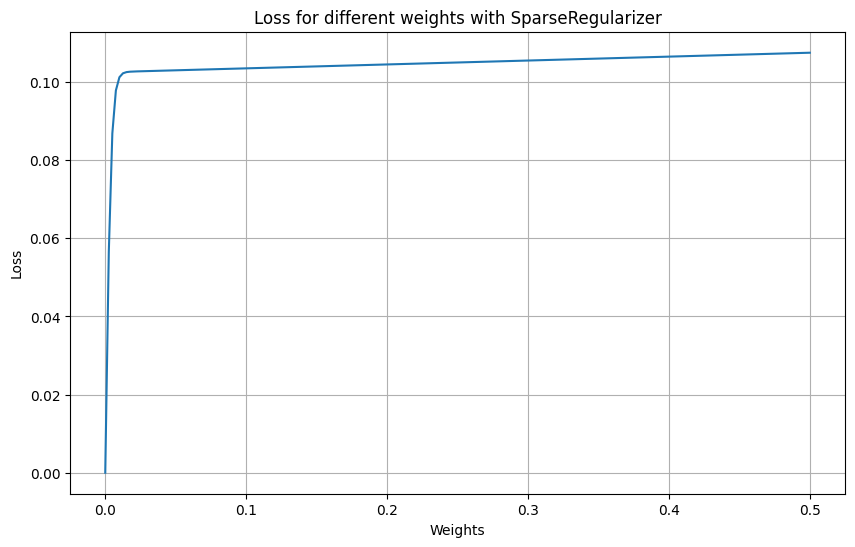

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# initialize the regularizer
reg = SparseRegularizer(intensity=0.1, threshold=0.0001, steepness=250, l1=0.01)

# create an array of weight values
weights = np.linspace(0, 0.5, 200)

# initialize an empty list to store the corresponding loss values
loss_values = []

# compute the loss for each weight
for weight in weights:
    weight_tensor = tf.constant(weight, shape=(1,1), dtype=tf.float32)
    loss = reg(weight_tensor)
    loss_values.append(loss.numpy())

# plot the results
plt.figure(figsize=(10, 6))
plt.plot(weights, loss_values)
plt.xlabel('Weights')
plt.ylabel('Loss')
plt.title('Loss for different weights with SparseRegularizer')
plt.grid(True)
plt.show()


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects


def ameo_grad(x):
    return tf.where(
        (x <= -1.0) & (x > -2.0) | ((x <= 1.0) & (x > 0.0)), 1.0, tf.where((x <= 0.0) & (x > -1.0), -1.0, 0.0)
    )


@tf.custom_gradient
def ameo(x, **kwargs):
    x *= 0.5
    x -= 0.5
    y = tf.where(x <= -1.0, tf.maximum(x + 2.0, 0.0), tf.where(x <= 0.0, -x, tf.minimum(x, 1.0)))
    y = (y - 0.5) * 2.0

    def grad(dy):
        return dy * ameo_grad(x)

    return y, grad


def soft_leaky_ameo_grad(x, leakyness):
    condition1_grad = tf.logical_and(-2 <= x, x <= -1.5)
    condition2_grad = tf.logical_and(-1.5 < x, x <= -0.5)
    condition3_grad = tf.logical_and(-0.5 < x, x <= 0.5)
    condition4_grad = tf.logical_and(0.5 < x, x <= 1)

    grad = tf.where(
        x <= -2,
        leakyness,
        tf.where(
            condition1_grad,
            32 * tf.pow(x + 2, 3),
            tf.where(
                condition2_grad,
                -32 * tf.pow(x, 3) - 96 * tf.pow(x, 2) - 96 * x - 32,
                tf.where(
                    condition3_grad,
                    32 * tf.pow(x, 3),
                    tf.where(condition4_grad, -32 * tf.pow(x, 3) + 96 * tf.pow(x, 2) - 96 * x + 32, leakyness),
                ),
            ),
        ),
    )
    return grad


@tf.custom_gradient
def soft_leaky_ameo(x, leakyness, **kwargs):
    x *= 0.5
    x -= 0.5

    condition1 = tf.logical_and(-2 <= x, x <= -1.5)
    condition2 = tf.logical_and(-1.5 < x, x <= -0.5)
    condition3 = tf.logical_and(-0.5 < x, x <= 0.5)
    condition4 = tf.logical_and(0.5 < x, x <= 1)

    y = tf.where(
        x <= -2,
        leakyness * (x + 2),
        tf.where(
            condition1,
            8 * tf.pow(x + 2, 4),
            tf.where(
                condition2,
                -8 * tf.pow(x, 4) - 32 * tf.pow(x, 3) - 48 * tf.pow(x, 2) - 32 * x - 7,
                tf.where(
                    condition3,
                    8 * tf.pow(x, 4),
                    tf.where(
                        condition4,
                        -8 * tf.pow(x, 4) + 32 * tf.pow(x, 3) - 48 * tf.pow(x, 2) + 32 * x - 7,
                        leakyness * (x - 1) + 1,
                    ),
                ),
            ),
        ),
    )
    y = (y - 0.5) * 2

    def grad(dy):
        return dy * soft_leaky_ameo_grad(x, leakyness), None

    return y, grad


@tf.custom_gradient
def interpolated_ameo(x, factor, leakyness, **kwargs):
    # print(factor)
    # if factor < 0 or factor > 1:
    #     raise ValueError("`factor` must be between 0 and 1")

    y0_mix = factor
    y1_mix = 1 - factor

    y0 = ameo(x) * y0_mix
    y1 = soft_leaky_ameo(x, leakyness) * y1_mix

    y = y0 + y1

    def grad(dy):
        dy0 = ameo_grad(x) * dy * y0_mix
        dy1 = soft_leaky_ameo_grad(x, leakyness) * dy * y1_mix
        return dy0 + dy1, None, None

    return y, grad


class AmeoActivation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AmeoActivation, self).__init__(**kwargs)

    def call(self, inputs):
        return ameo(inputs)

    def get_config(self):
        config = super(AmeoActivation, self).get_config()
        return config


class SoftLeakyAmeoActivation(tf.keras.layers.Layer):
    def __init__(self, leakyness, **kwargs):
        super(SoftLeakyAmeoActivation, self).__init__(**kwargs)
        self.leakyness = leakyness

    def call(self, inputs):
        return soft_leaky_ameo(inputs, self.leakyness)

    def get_config(self):
        config = super(SoftLeakyAmeoActivation, self).get_config()
        config["leakyness"] = self.leakyness
        return config


class InterpolatedAmeoActivation(tf.keras.layers.Layer):
    def __init__(self, factor, leakyness=0.05, **kwargs):
        super(InterpolatedAmeoActivation, self).__init__(**kwargs)
        self.factor = factor
        self.leakyness = float(leakyness)

    def call(self, inputs):
        return interpolated_ameo(inputs, self.factor, self.leakyness)

    def get_config(self):
        config = super(InterpolatedAmeoActivation, self).get_config()
        config["factor"] = self.factor
        config["leakyness"] = self.leakyness
        return config

2023-06-09 09:49:35.251657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.252243: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.252971: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.253427: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.253888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.254371: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.254819: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.255644: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35.256212: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:49:35

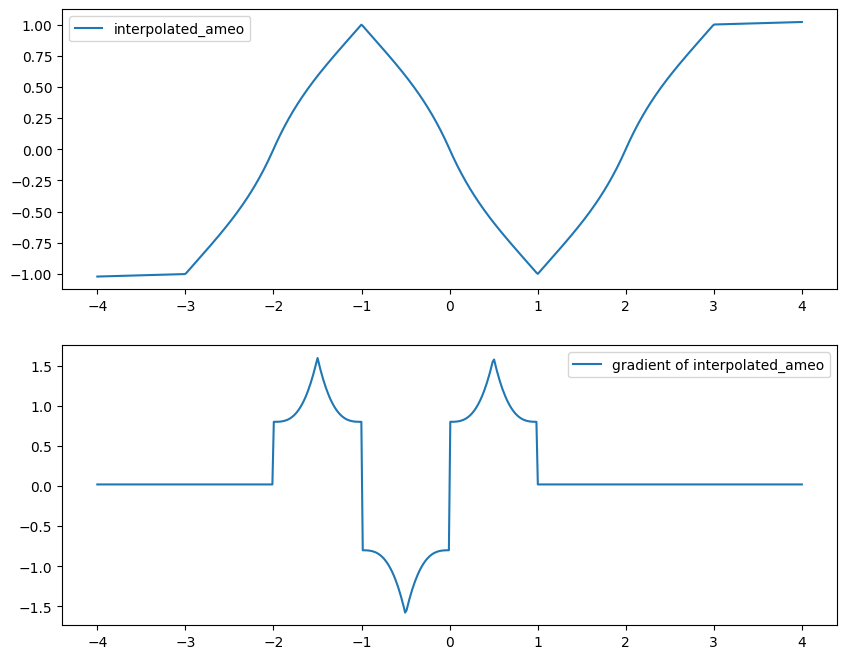

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

x = tf.linspace(-4., 4., num=500)
y = interpolated_ameo(x, 0.8, 0.1)
dy_dx = None

with tf.GradientTape() as g:
    g.watch(x)
    y = interpolated_ameo(x, 0.8, 0.1)
    dy_dx = g.gradient(y, x)

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(x, y, label='interpolated_ameo')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, dy_dx, label='gradient of interpolated_ameo')
plt.legend()

plt.show()


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard

def create_dataset(num_samples=1000, seq_len=10):
    X = np.random.choice([-1, 1], (num_samples, seq_len, 1))
    y = np.pad(X[:, :-1], ((0, 0), (1, 0), (0, 0))) # Shifting the sequence to the right
    y[:, 0, :] = -1 # Set first element to -1 rather than 0
    return X, y

seq_len = 12
reg = SparseRegularizer(intensity = 0.1, threshold=0.025, steepness=30, l1=0.01)
activation = InterpolatedAmeoActivation(0.6, leakyness=1)
input_layer = Input(shape=(seq_len, 1))
rnn_cell = CustomRNNCell(output_dim=4, state_size=2, activation=activation, trainable_initial_weights=True, kernel_regularizer=reg, recurrent_regularizer=reg)
rnn_layer = CustomRNN(rnn_cell, return_sequences=True)(input_layer)
dense_layer = Dense(1, kernel_regularizer=reg, activation='linear')(rnn_layer)
model = Model(inputs=input_layer, outputs=dense_layer)

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01))

# Training loop
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    X_train, y_train = create_dataset(2000, seq_len)
    model.fit(X_train, y_train, epochs=1, batch_size=128, verbose=1, callbacks=[])

# Print the weights, biases, and learned initial states
np.set_printoptions(suppress=True)
for layer in model.layers:
    if isinstance(layer, CustomRNN):
        print("Weights:")
        print(layer.cell.kernel.numpy())
        print("Recurrent Weights:")
        print(layer.cell.recurrent_kernel.numpy())
        if layer.cell.use_bias:
            print("Bias:")
            print(layer.cell.bias.numpy())
            print("Recurrent Bias:")
            print(layer.cell.recurrent_bias.numpy())
        if layer.cell.trainable_initial_weights:
            print("Initial state:")
            print(layer.cell.initial_state.numpy())


2023-06-09 09:52:37.482239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.482696: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.483996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.484344: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.484923: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.485261: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.485787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:37.486122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:38.013873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:38

Epoch 1/100


2023-06-09 09:52:41.156598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


16/16 [==============================] - 4s 9ms/step - loss: 2.1971
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 2.2169
Epoch 3/100
 1/16 [>.............................] - ETA: 0s - loss: 2.0647

2023-06-09 09:52:42.427836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.432667: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.436522: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.440364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.442998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.445011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.594860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.599856: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.603700: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42

16/16 [==============================] - 0s 9ms/step - loss: 1.9890
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 1.8608
Epoch 5/100
 1/16 [>.............................] - ETA: 0s - loss: 1.7704

2023-06-09 09:52:42.761348: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.766286: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.770098: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.773821: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.776429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.778372: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.930623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.935186: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42.938890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:42

16/16 [==============================] - 0s 9ms/step - loss: 1.6130
Epoch 6/100
16/16 [==============================] - 0s 9ms/step - loss: 1.3355
Epoch 7/100
 1/16 [>.............................] - ETA: 0s - loss: 1.2468

2023-06-09 09:52:43.096181: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.100735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.104406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.108018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.110656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.112562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.258827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.263280: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.267155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43

16/16 [==============================] - 0s 9ms/step - loss: 1.1742
Epoch 8/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0745
Epoch 9/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0295

2023-06-09 09:52:43.423429: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.428006: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.431662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.435315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.437804: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.439719: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.585245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.589731: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.593569: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43

16/16 [==============================] - 0s 9ms/step - loss: 0.9864
Epoch 10/100
16/16 [==============================] - 0s 9ms/step - loss: 0.9338
Epoch 11/100
 1/16 [>.............................] - ETA: 0s - loss: 0.9222

2023-06-09 09:52:43.751172: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.755939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.759598: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.763258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.765803: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.767701: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.913954: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.918292: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43.922121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:43

16/16 [==============================] - 0s 9ms/step - loss: 0.9114
Epoch 12/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8876
Epoch 13/100
 1/16 [>.............................] - ETA: 0s - loss: 0.8690

2023-06-09 09:52:44.078326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.082828: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.086617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.090222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.092749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.094648: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.243076: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.247829: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.251541: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44

16/16 [==============================] - 0s 9ms/step - loss: 0.8582
Epoch 14/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8186
Epoch 15/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7807

2023-06-09 09:52:44.405320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.410018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.413891: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.417622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.420144: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.422073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.568769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.573375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.577395: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44

16/16 [==============================] - 0s 9ms/step - loss: 0.7781
Epoch 16/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7541
Epoch 17/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7348

2023-06-09 09:52:44.732903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.737352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.741113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.744722: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.747187: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.749097: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.896027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.900386: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44.904305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:44

16/16 [==============================] - 0s 9ms/step - loss: 0.7175
Epoch 18/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8073
Epoch 19/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7821

2023-06-09 09:52:45.063464: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.068048: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.071638: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.075276: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.077749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.079643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.226975: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.231406: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.235059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45

16/16 [==============================] - 0s 9ms/step - loss: 0.7819
Epoch 20/100
16/16 [==============================] - 0s 9ms/step - loss: 0.7880
Epoch 21/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7257

2023-06-09 09:52:45.389360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.394116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.398162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.401903: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.404408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.406353: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.555130: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.560197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.563978: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45

16/16 [==============================] - 0s 9ms/step - loss: 0.6767
Epoch 22/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6443
Epoch 23/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6440

2023-06-09 09:52:45.718239: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.723287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.727246: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.730899: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.733367: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.735253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.880566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.884988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45.889044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:45

16/16 [==============================] - 0s 9ms/step - loss: 0.7615
Epoch 24/100
16/16 [==============================] - 0s 9ms/step - loss: 1.6916
Epoch 25/100
 1/16 [>.............................] - ETA: 0s - loss: 2.1583

2023-06-09 09:52:46.042654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.047382: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.051407: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.055142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.057662: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.059580: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.207011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.211717: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.215814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46

16/16 [==============================] - 0s 9ms/step - loss: 2.3595
Epoch 26/100
16/16 [==============================] - 0s 9ms/step - loss: 1.6760
Epoch 27/100
 1/16 [>.............................] - ETA: 0s - loss: 1.5014

2023-06-09 09:52:46.368711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.373303: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.377167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.380771: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.383206: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.385091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.532408: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.537510: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.541735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46

16/16 [==============================] - 0s 9ms/step - loss: 1.4938
Epoch 28/100
16/16 [==============================] - 0s 9ms/step - loss: 1.4991
Epoch 29/100
 1/16 [>.............................] - ETA: 0s - loss: 1.5657

2023-06-09 09:52:46.701256: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.706459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.710540: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.714401: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.717128: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.719125: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.870107: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.874506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46.878155: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:46

16/16 [==============================] - 0s 9ms/step - loss: 1.5609
Epoch 30/100
16/16 [==============================] - 0s 9ms/step - loss: 1.5024
Epoch 31/100
 1/16 [>.............................] - ETA: 0s - loss: 1.4641

2023-06-09 09:52:47.033933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.038587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.042162: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.045735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.048192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.050071: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.194712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.199046: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.202770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47

16/16 [==============================] - 0s 9ms/step - loss: 1.4232
Epoch 32/100
16/16 [==============================] - 0s 9ms/step - loss: 1.3197
Epoch 33/100
 1/16 [>.............................] - ETA: 0s - loss: 1.2703

2023-06-09 09:52:47.356113: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.360518: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.364320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.367840: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.370289: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.372166: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.521039: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.525341: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.529094: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47

16/16 [==============================] - 0s 9ms/step - loss: 1.2245
Epoch 34/100
16/16 [==============================] - 0s 9ms/step - loss: 1.0896
Epoch 35/100
 1/16 [>.............................] - ETA: 0s - loss: 1.0076

2023-06-09 09:52:47.682443: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.686890: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.690684: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.694209: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.696649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.698515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.842108: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.846424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47.850027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:47

16/16 [==============================] - 0s 9ms/step - loss: 0.9330
Epoch 36/100
16/16 [==============================] - 0s 9ms/step - loss: 0.8158
Epoch 37/100
 1/16 [>.............................] - ETA: 0s - loss: 0.7443

2023-06-09 09:52:48.002789: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.007179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.010712: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.014230: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.016680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.018546: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.166989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.171361: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.174988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48

16/16 [==============================] - 0s 9ms/step - loss: 0.6936
Epoch 38/100
16/16 [==============================] - 0s 9ms/step - loss: 0.6425
Epoch 39/100
 1/16 [>.............................] - ETA: 0s - loss: 0.6227

2023-06-09 09:52:48.328674: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.333170: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.337038: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.340599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.343066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.344957: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.490322: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.494717: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.498589: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48

16/16 [==============================] - 0s 9ms/step - loss: 0.6102
Epoch 40/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5941
Epoch 41/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5874

2023-06-09 09:52:48.649869: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.654283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.657818: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.661345: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.663814: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.665692: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.809073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.813419: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.816995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48

16/16 [==============================] - 0s 9ms/step - loss: 0.5777
Epoch 42/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5714
Epoch 43/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5694

2023-06-09 09:52:48.967061: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.971471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.975099: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.978599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.981021: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:48.982900: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.127359: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.131683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.135257: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49

16/16 [==============================] - 0s 9ms/step - loss: 0.5679
Epoch 44/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5657
Epoch 45/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5643

2023-06-09 09:52:49.284858: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.289312: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.292935: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.296414: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.298836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.300721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.446028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.450441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.454112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49

16/16 [==============================] - 0s 8ms/step - loss: 0.5632
Epoch 46/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5545
Epoch 47/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5537

2023-06-09 09:52:49.603132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.607619: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.611185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.614743: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.617196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.619084: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.773264: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.777795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.781470: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49

16/16 [==============================] - 0s 8ms/step - loss: 0.5494
Epoch 48/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5478
Epoch 49/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5475

2023-06-09 09:52:49.930937: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.935556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.939106: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.942646: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.945075: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:49.946983: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.089796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.094156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.097775: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50

16/16 [==============================] - 0s 9ms/step - loss: 0.5472
Epoch 50/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5471
Epoch 51/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5464

2023-06-09 09:52:50.247655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.252051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.255558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.259078: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.261496: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.263388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.411320: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.416253: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.420626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50

16/16 [==============================] - 0s 9ms/step - loss: 0.5469
Epoch 52/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5467
Epoch 53/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5470

2023-06-09 09:52:50.577837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.582886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.586686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.590388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.592843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.594735: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.745283: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.750065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.753914: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50

16/16 [==============================] - 0s 9ms/step - loss: 0.5468
Epoch 54/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5465
Epoch 55/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5464

2023-06-09 09:52:50.910530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.915268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.918961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.922633: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.925120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:50.927013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.073924: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.078603: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.082998: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51

16/16 [==============================] - 0s 9ms/step - loss: 0.5463
Epoch 56/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5464
Epoch 57/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5460

2023-06-09 09:52:51.241944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.247053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.251145: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.254918: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.257517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.259423: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.408069: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.413236: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.417198: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51

16/16 [==============================] - 0s 9ms/step - loss: 0.5461
Epoch 58/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5460
Epoch 59/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5450

2023-06-09 09:52:51.573699: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.578847: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.582911: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.586647: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.589100: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.590988: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.740013: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.744961: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.748757: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51

16/16 [==============================] - 0s 9ms/step - loss: 0.5364
Epoch 60/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5337
Epoch 61/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5339

2023-06-09 09:52:51.904720: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.909375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.913247: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.917136: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.919630: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:51.921541: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.073282: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.078159: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.082116: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52

16/16 [==============================] - 0s 9ms/step - loss: 0.5332
Epoch 62/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5331
Epoch 63/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5322

2023-06-09 09:52:52.239124: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.243725: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.247544: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.251285: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.253827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.255754: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.406972: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.411604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.415444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52

16/16 [==============================] - 0s 9ms/step - loss: 0.5328
Epoch 64/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5327
Epoch 65/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5326

2023-06-09 09:52:52.573424: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.577950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.581626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.585275: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.587693: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.589557: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.738456: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.743315: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.747254: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52

16/16 [==============================] - 0s 9ms/step - loss: 0.5327
Epoch 66/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5326
Epoch 67/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5328

2023-06-09 09:52:52.902413: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.906864: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.910665: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.914211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.916626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:52.918492: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.068346: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.072969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.076639: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53

16/16 [==============================] - 0s 9ms/step - loss: 0.5325
Epoch 68/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5325
Epoch 69/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5313

2023-06-09 09:52:53.234431: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.239057: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.242675: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.246248: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.248732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.250582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.401989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.406622: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.410621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53

16/16 [==============================] - 0s 9ms/step - loss: 0.5323
Epoch 70/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5322
Epoch 71/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5326

2023-06-09 09:52:53.568853: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.573473: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.577374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.581129: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.583683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.585576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.735960: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.740504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.744164: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53

16/16 [==============================] - 0s 9ms/step - loss: 0.5323
Epoch 72/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5322
Epoch 73/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5322

2023-06-09 09:52:53.902779: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.907404: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.911051: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.914777: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.917204: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:53.919220: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.068516: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.073142: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.076792: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54

16/16 [==============================] - 0s 9ms/step - loss: 0.5320
Epoch 74/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5310
Epoch 75/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5206

2023-06-09 09:52:54.234535: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.239211: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.242812: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.246374: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.248839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.250723: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.398842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.403185: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.406860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54

16/16 [==============================] - 0s 9ms/step - loss: 0.5206
Epoch 76/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5191
Epoch 77/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5194

2023-06-09 09:52:54.565680: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.570748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.574691: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.578584: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.581082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.583042: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.737218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.742000: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.745989: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54

16/16 [==============================] - 0s 9ms/step - loss: 0.5191
Epoch 78/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5189
Epoch 79/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5181

2023-06-09 09:52:54.903944: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.908576: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.912354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.916047: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.918554: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:54.920499: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.068143: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.073156: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.077028: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55

16/16 [==============================] - 0s 9ms/step - loss: 0.5187
Epoch 80/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5187
Epoch 81/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5184

2023-06-09 09:52:55.235237: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.239970: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.243614: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.247192: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.249683: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.251555: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.399169: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.403734: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.407676: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55

16/16 [==============================] - 0s 9ms/step - loss: 0.5186
Epoch 82/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5185
Epoch 83/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5185

2023-06-09 09:52:55.564530: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.569354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.572952: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.576571: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.579027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.580946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.728272: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.732677: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.736393: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55

16/16 [==============================] - 0s 9ms/step - loss: 0.5184
Epoch 84/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5094
Epoch 85/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5061

2023-06-09 09:52:55.892939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.897859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.901505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.905152: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.907654: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:55.909564: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.059850: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.064670: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.068454: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56

16/16 [==============================] - 0s 9ms/step - loss: 0.5062
Epoch 86/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5058
Epoch 87/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5052

2023-06-09 09:52:56.224943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.229753: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.233388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.237077: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.239552: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.241471: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.388874: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.393366: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.397056: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56

16/16 [==============================] - 0s 9ms/step - loss: 0.5055
Epoch 88/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5053
Epoch 89/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5046

2023-06-09 09:52:56.554788: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.560091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.563995: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.567760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.570290: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.572197: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.721469: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.726255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.729976: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56

16/16 [==============================] - 0s 9ms/step - loss: 0.5052
Epoch 90/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5051
Epoch 91/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5052

2023-06-09 09:52:56.887463: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.892572: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.896490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.900154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.902632: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:56.904531: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.053991: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.058649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.062600: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57

16/16 [==============================] - 0s 9ms/step - loss: 0.5051
Epoch 92/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5050
Epoch 93/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5044

2023-06-09 09:52:57.220645: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.225793: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.229791: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.233637: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.236154: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.238082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.388305: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.392916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.396633: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57

16/16 [==============================] - 0s 9ms/step - loss: 0.5049
Epoch 94/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5048
Epoch 95/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5046

2023-06-09 09:52:57.551226: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.555999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.559671: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.563369: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.565872: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.567795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.713928: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.718327: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.722225: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57

16/16 [==============================] - 0s 9ms/step - loss: 0.5048
Epoch 96/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5047
Epoch 97/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5049

2023-06-09 09:52:57.879255: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.885314: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.889233: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.893375: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.895880: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:57.897827: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.045844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.050517: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.054355: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58

16/16 [==============================] - 0s 9ms/step - loss: 0.5046
Epoch 98/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5051
Epoch 99/100
 1/16 [>.............................] - ETA: 0s - loss: 0.5033

2023-06-09 09:52:58.210950: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.215760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.219378: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.222933: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.225388: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.227277: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.375064: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.379999: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.383837: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58

16/16 [==============================] - 0s 9ms/step - loss: 0.5044
Epoch 100/100
16/16 [==============================] - 0s 9ms/step - loss: 0.5049
Weights:
[[ 0.48892882 -0.8312438  -0.10280956  0.00190509]
 [ 0.00136472 -0.00189839 -0.00231255 -0.00064262]
 [ 0.00479346  0.7256798  -0.00164934  1.6223618 ]]
Recurrent Weights:
[[ 0.19497263  0.5091688 ]
 [ 1.2023176  -0.00151236]
 [-0.00324715 -0.00129733]]
Bias:
[0.58218807 0.53639454 0.35646263 1.3335382 ]
Recurrent Bias:
[ 0.3437402  -0.47407895]
Initial state:
[-0.5055874   0.99322075]


2023-06-09 09:52:58.540778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.545841: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.549547: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.553229: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.555721: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.557655: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.701481: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.702134: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58.702657: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:52:58

In [10]:
# Generate a sequence
X_test, y_test = create_dataset(num_samples=1, seq_len=seq_len)

# Predict the output sequence
y_pred = model.predict(X_test)

# Print the input and output sequences
print("Input sequence:")
print(X_test[0])
print("True output sequence:")
print(y_test[0])
print("Predicted output sequence:")
print(y_pred[0])


2023-06-09 09:53:10.029599: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:53:10.037862: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:53:10.040711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:53:10.045122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:53:10.048009: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
2023-06-09 09:53:10.049969: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.


1/1 [==============================] - 1s 891ms/step
Input sequence:
[[-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]]
True output sequence:
[[-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]]
Predicted output sequence:
[[-1.0102682]
 [-1.0065255]
 [-1.0083642]
 [-1.0071788]
 [ 1.0491452]
 [-1.0057166]
 [-1.0094914]
 [ 1.0562344]
 [-1.0087681]
 [ 1.0513773]
 [ 1.0476873]
 [ 1.0585167]]


2023-06-09 09:53:10.911011: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:507] ROCm Fusion is enabled.
